# Schramm Plot

In this notebook, we will make the Schramm plot, which shows the dependence on the primordial abundance of various elements as a function of the baryon-to-photon ratio, $\eta$.

## Preamble

LINX is written using the JAX framework. Functions are compiled on the first run. Subsequent calls to the same function with input parameters of the same shape and type will rely on the compiled version, and are much faster.

In [1]:
# !pip install -r https://raw.githubusercontent.com/cgiovanetti/LINX/GGI_tutorial/requirements.txt

!git clone -b GGI_tutorial https://github.com/cgiovanetti/LINX.git
%cd LINX
!pip install -r requirements.txt
!pip install .

fatal: destination path 'LINX' already exists and is not an empty directory.
/content/LINX
  Using cached pathtools-0.1.2.tar.gz (11 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
# %load_ext autoreload
# %autoreload
import jax.numpy as jnp
import jax
from jax import jit, vmap
import sys

sys.path.append("../")
import linx.const as const
from linx.nuclear import NuclearRates
from linx.background import BackgroundModel
from linx.abundances import AbundanceModel

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline

import sys
sys.path.append("/content/LINX/example_notebooks")

plt.rc('text', usetex=False)

from plot_params import params
matplotlib.pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipython-input-3287934743.py:34: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Thermodynamics

See "background_evolution" notebook for more information about the LINX computation of background thermodynamics.

In [3]:
thermo_model_DNeff = BackgroundModel()

(
    t_vec_ref, a_vec_ref, rho_g_vec, rho_nu_vec, rho_NP_vec, P_NP_vec, Neff_vec
) = thermo_model_DNeff(jnp.asarray(0.))


`\         /´  ||||        ||||  |||||     ||||  ||||   ||||
 /\_______/\   ||||        ||||  |||||||   ||||   |||| ||||
 ) __` ´__ (   ||||        ||||  |||| |||| ||||    |||||||
/  `-|_|-´  \  ||||        ||||  ||||  |||| |||    ||||||| 
/   (_x_)   \  ||||||||||  ||||  ||||   |||||||   |||| ||||
  )  `-´  (    ||||||||||  ||||  ||||    ||||||  ||||   ||||
 
Compiling thermodynamics model...


## Abundance Model

With the thermodynamics computed, we now want to determine the abundance of the light elements. We first have to choose a nuclear network to use for our prediction. See <??> for a full list of options. Here, we will use the small network of 12 reactions provided by PRIMAT in 2023.

The abundance calculation is contained within the class `abundances.AbundanceModel`. In the simplest use case, we can instantiate the class with a choice of network.

In [4]:
# comment or uncomment to toggle which reaction network to use

network = 'key_PRIMAT_2023'
# network = 'key_PRIMAT_2018'
# network = 'key_PArthENoPE'
# network = 'key_YOF'
abundance_model = AbundanceModel(NuclearRates(nuclear_net=network))

# Schramm plot without Rate Uncertainties

We are now ready to generate a version of the Schramm plot, with no rate uncertainties included, i.e. we will use the mean nuclear rates provided by the network choice above. We will then perform the BBN calculation over `num_pts` different values of $\Omega_b h^2$, which is stored in `omega_b`.

In [5]:
num_pts = 50
omega_b = jnp.logspace(jnp.log10(3e-3),jnp.log10(6e-2),num=num_pts)

First, for clarity, get the abundances at the Planck central value for $\Omega_b h^2$ by calling `abundance_model`, and specifying `eta_fac = 1`. `eta_fac` here is the ratio of our choice of $\eta$ or equivalently $\Omega_b h^2$ to the Planck central value.

Once again, the function is compiled on its first run. Subsequent runs will be much faster, as long as the inputs are of the same shape and type.

The output is an array of floats, representing the abundances ($n_i$/$n_b$) of 0:n, 1:p, 2:d, 3:t, 4:He3, 5:He4 (frequently denoted a), 6:Li7, 7:Be7, 8: He6, 9: Li6, 10: Li8, 11:B8. The size of the output depends on the choice of network.

In [6]:
Planck_omega_b_res = abundance_model(
    rho_g_vec, # photon energy density
    rho_nu_vec, # neutrino energy density
    rho_NP_vec, # energy density of extra species
    P_NP_vec, # pressure of extra species
    t_vec=t_vec_ref, # vector of times at which quantities are given
    a_vec=a_vec_ref, # vector of scale factor at corresponding times
    eta_fac=jnp.asarray(1.), # factor by which to scale baryon-to-photon ratio
)

print('The abundances (n_i/n_b) are: ')
print('n:   ', Planck_omega_b_res[0])
print('p:   ', Planck_omega_b_res[1])
print('d:   ', Planck_omega_b_res[2])
print('t:   ', Planck_omega_b_res[3])
print('He3: ', Planck_omega_b_res[4])
print('He4: ', Planck_omega_b_res[5])
print('')
print('More standard abundances are: ')
print('D/H:   ', Planck_omega_b_res[2]/Planck_omega_b_res[1])
print('T/H:   ', Planck_omega_b_res[3]/Planck_omega_b_res[1])
print('He3/H:   ', Planck_omega_b_res[5]/Planck_omega_b_res[1])
print('Yp: ', 4*Planck_omega_b_res[5])
print('Li7/H:   ', Planck_omega_b_res[6]/Planck_omega_b_res[1])

Compiling abundance model...
The abundances (n_i/n_b) are: 
n:    7.223115326266486e-11
p:    0.7527982318660903
d:    1.832824993745494e-05
t:    5.84355921571049e-08
He3:  7.737092656419245e-06
He4:  0.06178543049523205

More standard abundances are: 
D/H:    2.434682915237667e-05
T/H:    7.762450771470405e-08
He3/H:    0.08207435655377922
Yp:  0.2471417219809282
Li7/H:    2.9046067500663913e-11


To scan over `omega_b`, we use JAX to construct a vectorized function call to `abundance_model`, which can then be compiled, and runs significantly faster than a `for` loop. We first define a wrapper function `get_abundance_eta`, which calls the abundance model for a value of `eta_fac`, and then use `vmap` to construct new function that is vectorized, i.e. it will take a vector `eta_fac_vec` of `eta_fac` values and output a 2D array of abundances, of size (`eta_fac_vec`, number of light elements).

In [7]:
def get_abundance_eta(eta_fac):
    return abundance_model(
        rho_g_vec, # photon energy density
        rho_nu_vec, # neutrino energy density
        rho_NP_vec, # energy density of extra species
        P_NP_vec, # pressure of extra species
        t_vec=t_vec_ref, # vector of times at which quantities are given
        a_vec=a_vec_ref, # vector of scale factor at corresponding times
        eta_fac=jnp.asarray(eta_fac), # factor by which to scale baryon-to-photon ratio
    )

get_abundance = jit(vmap(get_abundance_eta, in_axes=0))

We are now ready to run the vectorized code (which will perform 100 BBN evaluations). First the code is compiled, and then executed. We then rearrange the results into a series of arrays for each of the light elements.

In [8]:
results = get_abundance(omega_b/const.Omegabh2)

Yn_arr, Yp_arr, Yd_arr, Yt_arr, YHe3_arr, Ya_arr, YLi7_arr, YBe7_arr = (
    results.transpose()
)

Compiling abundance model...


In [9]:
# Check that compiled function runs much faster
results = get_abundance(1.02*omega_b/const.Omegabh2)


Make the Schramm plot. We use constraints on $Y_\mathrm{p}$ from Aver+ 2015 (arXiv:1503.08146), $\mathrm{D/H}$ from Cooke+ 2018 (arXiv:1710.11129) and on $^7\mathrm{Li/H}$ from the PDG. This plot can be compared to the same one found in the PDG review of BBN, Figure 23.1.

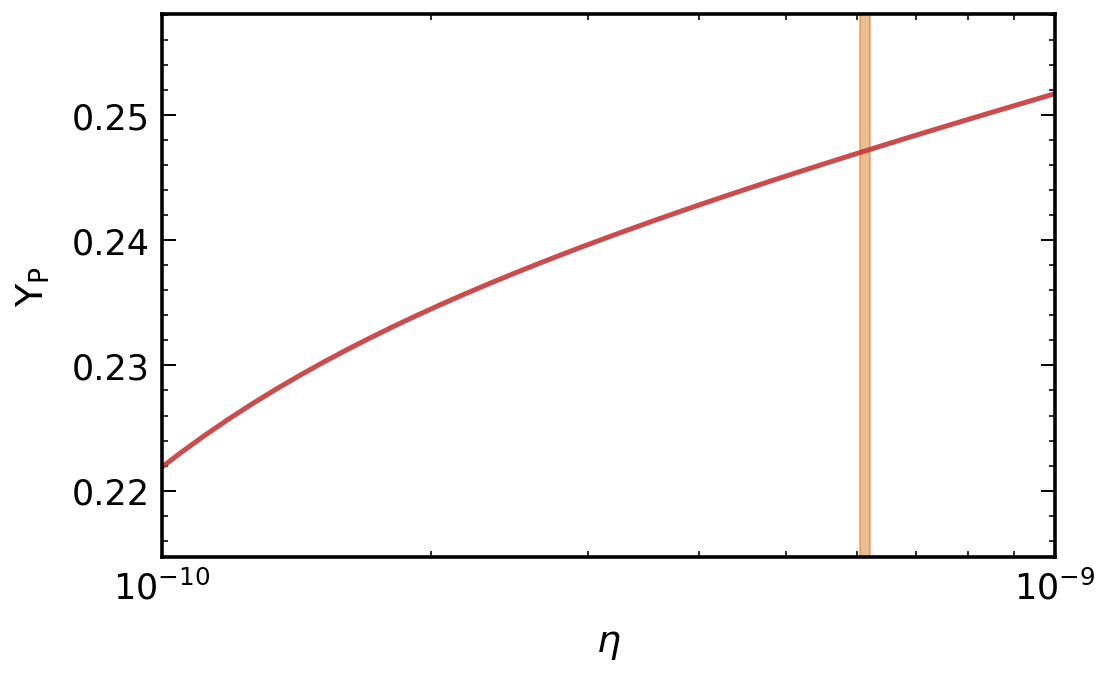

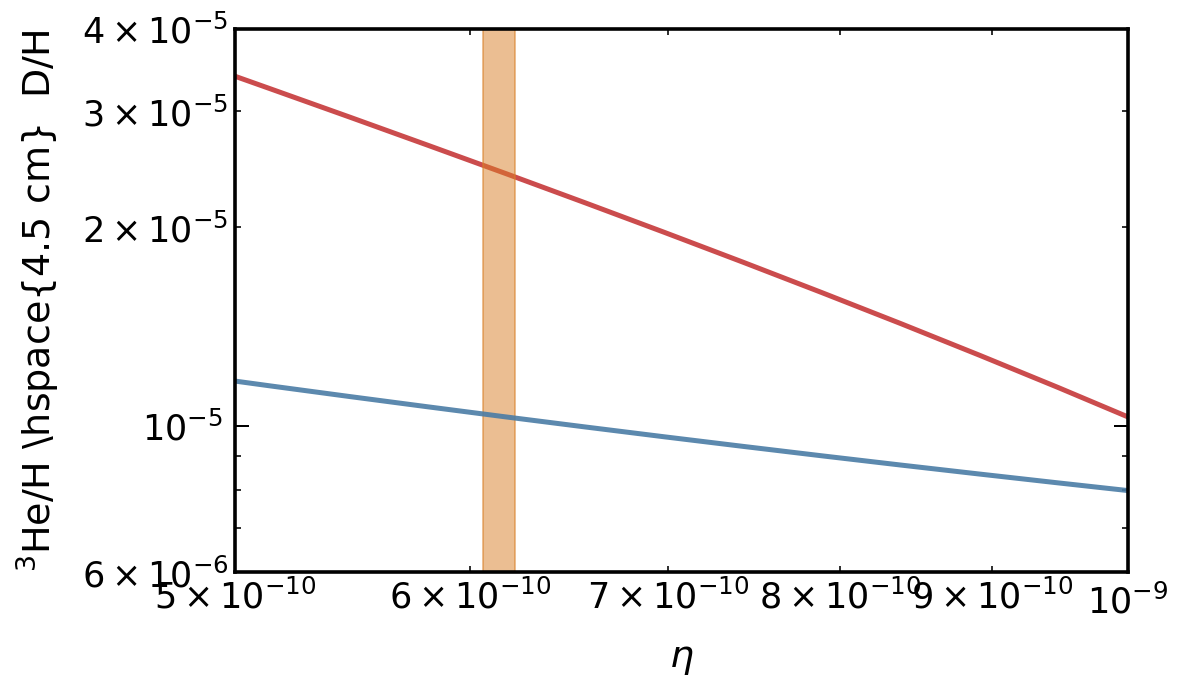

Text(0, 0.5, '$^7$Li/H')

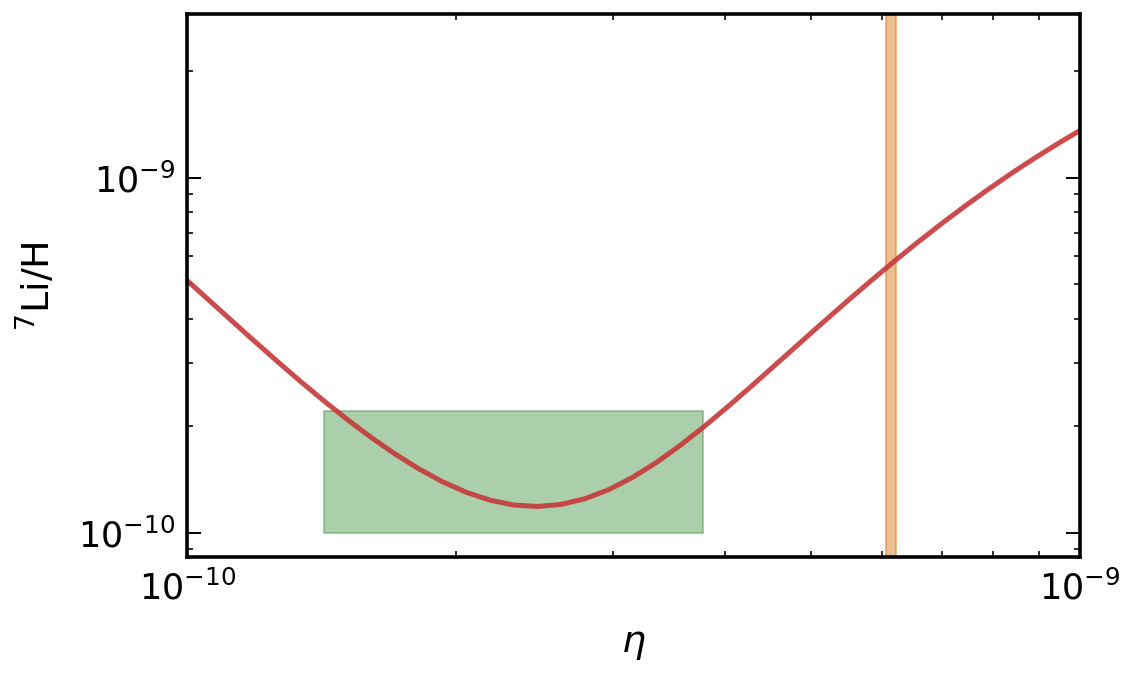

In [10]:
# Conversion between omega_b and eta.
eta = omega_b * const.Omegabh2_to_eta0

# Planck central values.
omb = const.Omegabh2
sigma_omb = const.sigma_Omegabh2

eta0 = omb * const.Omegabh2_to_eta0
sigma_eta0 = sigma_omb / omb * eta0

# Aver 2015 Yp:
YHe_BBN = 0.2449
YHe_BBN_sigma = 0.004

# Cooke 2018 D/H:
DH_BBN = 2.527*1e-5
DH_BBN_sigma = 0.030 *1e-5

# PDG 2021 Li7/H:
Li7_BBN = 1.6e-10
Li7_BBN_sigma = 0.3e-10

plt.rc('text', usetex=False)

###############################
###############################
###############################

fig = plt.figure(figsize=(8, 5))
plt.plot(eta, 4*Ya_arr)
ax = plt.gca()
ax.axvspan(
    eta0 - 2*sigma_eta0, eta0 + 2*sigma_eta0, alpha=0.5, color=cols_default[4]
)
idx_low = jnp.argmin(jnp.abs(4*Ya_arr - (YHe_BBN-2*YHe_BBN_sigma)))
idx_high = jnp.argmin(jnp.abs(4*Ya_arr - (YHe_BBN+2*YHe_BBN_sigma)))
# ax.fill_between(
#     np.array([eta[idx_low],eta[idx_high]]).flatten(),
#     YHe_BBN-2*YHe_BBN_sigma,YHe_BBN+2*YHe_BBN_sigma,
#     color=cols_default[2], alpha = 0.5
# )

ax.set_xscale('log')
ax.set_xlim(1e-10, 1e-9)
plt.xlabel(r'$\eta$')
plt.ylabel(r'Y$_{\rm P}$')
plt.show()

###############################
###############################
###############################

fig = plt.figure(figsize=(8, 5))
plt.loglog(eta, Yd_arr/Yp_arr,label='D/H',zorder=1)
plt.loglog(eta, YHe3_arr/Yp_arr+Yt_arr/Yp_arr,label='He3/H')
ax = plt.gca()
ax.axvspan(
    eta0 - 2*sigma_eta0, eta0 + 2*sigma_eta0, alpha=0.5, color=cols_default[4]
)
idx_low = jnp.argmin(jnp.abs(Yd_arr/Yp_arr - (DH_BBN-2*DH_BBN_sigma)))
idx_high = jnp.argmin(jnp.abs(Yd_arr/Yp_arr- (DH_BBN+2*DH_BBN_sigma)))
# ax.fill_between(np.array([eta[idx_low],eta[idx_high]]).flatten(),DH_BBN-2*DH_BBN_sigma,DH_BBN+2*DH_BBN_sigma,color=cols_default[2],alpha = 0.5,zorder=2)

ax.set_xlim(5e-10, 1e-9)
ax.set_ylim(6e-6, 4e-5)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$^3$He/H \hspace{4.5 cm}  D/H')
plt.show()

###############################
###############################
###############################

fig = plt.figure(figsize=(8, 5))
plt.loglog(eta, YLi7_arr/Yp_arr+YBe7_arr/Yp_arr) # Be7 decays to Li7
ax = plt.gca()
ax.axvspan(
    eta0 - 2*sigma_eta0, eta0 + 2*sigma_eta0, alpha=0.5, color=cols_default[4]
)
idx_low = jnp.argwhere(jnp.diff(jnp.sign(YLi7_arr/Yp_arr+YBe7_arr/Yp_arr - (Li7_BBN-2*Li7_BBN_sigma)))).flatten()
idx_high = jnp.argwhere(jnp.diff(jnp.sign(YLi7_arr/Yp_arr+YBe7_arr/Yp_arr - (Li7_BBN+2*Li7_BBN_sigma)))).flatten()
# adjust for two intersections
ax.fill_between(jnp.array([eta[idx_high[0]],eta[idx_high[-1]]]).flatten(),Li7_BBN-2*Li7_BBN_sigma,Li7_BBN+2*Li7_BBN_sigma,color=cols_default[2],alpha = 0.5,zorder=0)

ax.set_xlim(1e-10, 1e-9)
plt.xlabel(r'$\eta$')
plt.ylabel('$^7$Li/H')

# Generate Schramm plot with uncertainties

A major advantage of LINX is the ease with which it can calculate abundances in a way that accounts for the uncertainties on nuclear reaction rates in the BBN network.  Let's see that in action.

First, we define our thermodynamics and abundance models.  We'll start with a "key" network, and move on to the "full" network later.

In [11]:
(
    t_vec_ref, a_vec_ref, rho_g_vec, rho_nu_vec, rho_NP_vec, P_NP_vec, Neff_vec
) = thermo_model_DNeff(jnp.asarray(0.))

abundance_model_key_PRIMAT_2023 = AbundanceModel(
    NuclearRates(nuclear_net='key_PRIMAT_2023'))

The rate for each nuclear reaction $i$ is $r_i(T) \equiv u^{-1} \langle \sigma v \rangle (T)$, where $u$ is the atomic mass unit, $\langle \sigma v \rangle$.  Rate uncertainties in LINX are captured by taking $r_i$ to be log-normally distributed, with a mean value $ \overline{r}_i(T)$ and standard deviation $\sigma_i(T)$.  Specifically, $\log r_i (T) = \log \overline{r}_i (T) + q_i \sigma_i (T)$, where $q_i$ is a unit Gaussian random variable.

Let's define a new wrapper function that takes an argument for `nuclear_rates_q`, where `nuclear_rates_q` is an array of $q_i$.  Passing in nonzero values for the entries of `nuclear_rates_q` will allow us to vary the nuclear rates.

In [12]:
def get_abundance_eta_q(eta_fac, tau_n_fac, nuclear_rates_q):
    Yn, Yp, Yd, Yt, YHe3, Ya, YLi7, YBe7 = abundance_model_key_PRIMAT_2023(
        rho_g_vec,
        rho_nu_vec,
        jnp.zeros_like(rho_g_vec),
        jnp.zeros_like(rho_g_vec),
        t_vec=t_vec_ref,
        a_vec=a_vec_ref,
        eta_fac=jnp.asarray(eta_fac),
        tau_n_fac=jnp.asarray(tau_n_fac),
        nuclear_rates_q=nuclear_rates_q
    )
    return jnp.array([Yn, Yp, Yd, Yt, YHe3, Ya, YLi7, YBe7])

get_abundance = jit(vmap(vmap(get_abundance_eta_q, in_axes=(None, 0, 0)), in_axes=(0, None, None)))

The last line above vectorizes input over the nuisance parameters `tau_n_fac` and `nuclear_rates_q`, then vectorizes over `eta_fac`.

Now we sample over random inputs for the nuisance parameters, as well as the same vector of $\Omega_b h^2$ values used above:

In [13]:
key = jax.random.PRNGKey(0)
n_reactions = len(abundance_model_key_PRIMAT_2023.nuclear_net.reactions)

key, subkey = jax.random.split(key)
nuclear_rates_q = jax.random.normal(subkey, (25, n_reactions))
tau_n_fac = 1. + jax.random.normal(subkey, (25,)) * 0.000682

res_key = get_abundance(omega_b/const.Omegabh2, tau_n_fac, nuclear_rates_q)

Compiling abundance model...


Finally, we unpack the data and plot it.  As above, we add the tritium abundance to the $^3$He line and the $^7$Be abundance to the $^7$Li line to account for prompt decay of these two species.

In [14]:
# Unpack results
Yp_arr_key = res_key[:, :, 1]
Yd_arr_key = res_key[:, :, 2]
Yt_arr_key = res_key[:, :, 3]
YHe3_arr_key = res_key[:, :, 4]
Ya_arr_key = res_key[:, :, 5]
YLi7_arr_key = res_key[:, :, 6]
YBe7_arr_key = res_key[:, :, 7]

In [15]:
Yp_plot_key = jnp.mean(4*Ya_arr_key,1)
DH_plot_key = jnp.mean(Yd_arr_key/Yp_arr_key,1)
He3H_plot_key = jnp.mean(YHe3_arr_key/Yp_arr_key + Yt_arr_key/Yp_arr_key,1)
Li7H_plot_key = jnp.mean(YLi7_arr_key/Yp_arr_key + YBe7_arr_key/Yp_arr_key,1)

Yp_plot_sigma_key = jnp.std(4*Ya_arr_key,1)
DH_plot_sigma_key = jnp.std(Yd_arr_key/Yp_arr_key,1)
He3H_plot_sigma_key = jnp.std(YHe3_arr_key/Yp_arr_key + Yt_arr_key/Yp_arr_key,1)
Li7H_plot_sigma_key = jnp.std(YLi7_arr_key/Yp_arr_key + YBe7_arr_key/Yp_arr_key,1)

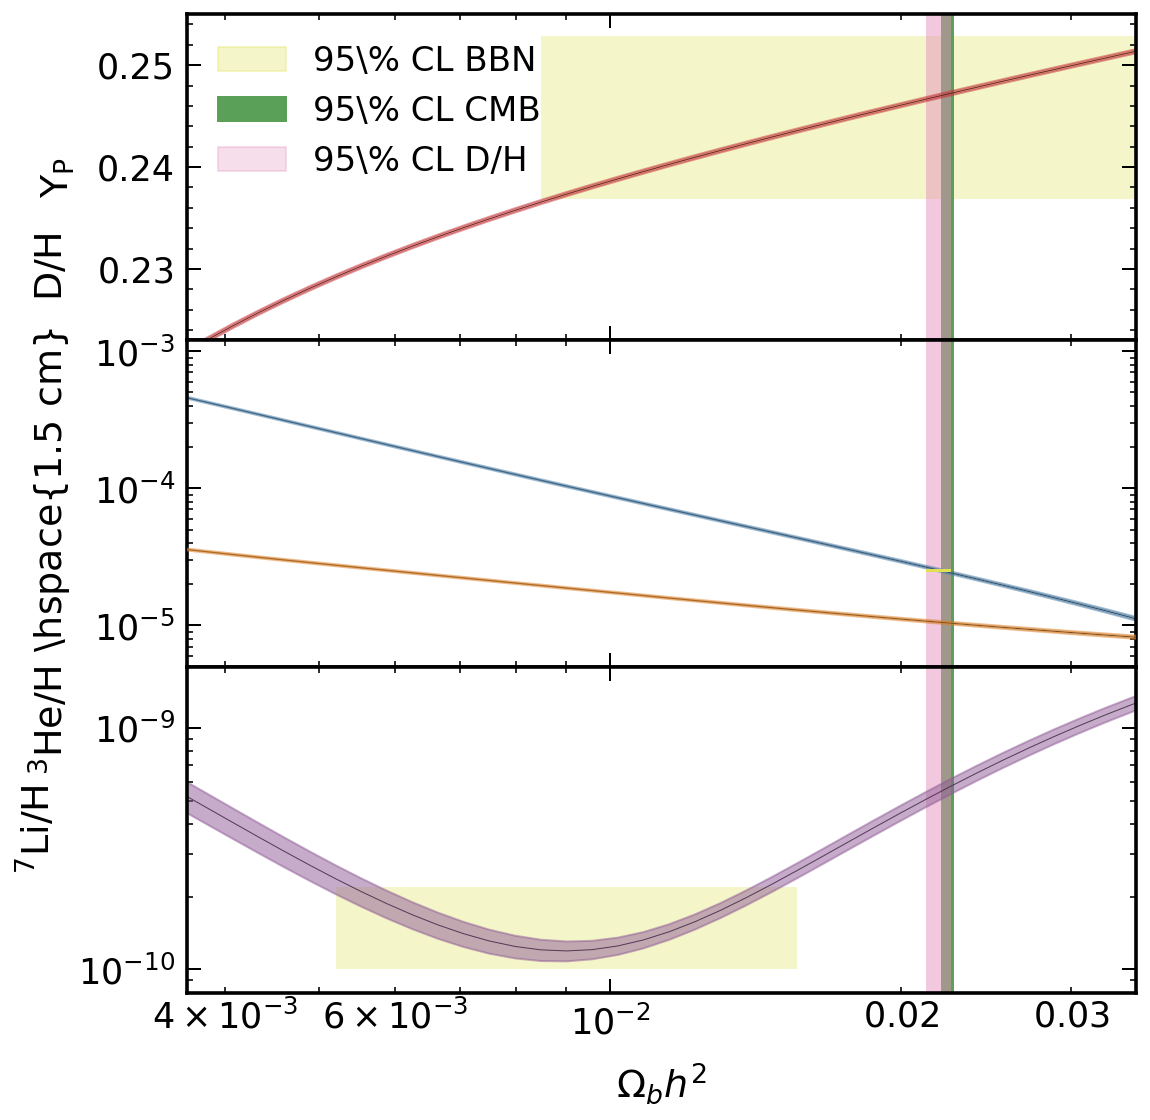

In [16]:
# generate the plot with uncertainties
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8.5, 9))

# Planck LCDM omega_b:
omb = 2.236*1e-2
sigma_omb = 0.015*1e-2

# Aver 2015 Yp:
YHe_BBN = 0.2449
YHe_BBN_sigma = 0.004

# Cooke 2018 D/H:
DH_BBN = 2.527*1e-5
DH_BBN_sigma = 0.030 *1e-5

# Cooke 2018 D/H:
DH_BBN = 2.527*1e-5
DH_BBN_sigma = 0.030 *1e-5

# PDG 2021 Li7*:
Li7_BBN = 1.6e-10
Li7_BBN_sigma = 0.3e-10

###############################
###############################
###############################

axs[0].plot(omega_b, Yp_plot_key, lw=0.5, color='k', zorder=2)
axs[0].fill_between(
    omega_b, Yp_plot_key - 2*Yp_plot_sigma_key, Yp_plot_key + 2*Yp_plot_sigma_key,
    color=cols_default[0],alpha=0.5, zorder=2
)

axs[0].axvspan(
    omb - 2*sigma_omb, omb + 2*sigma_omb,
    alpha=1., color=cols_default[2], zorder=1
)
# find the low value of omega_b with the "high" curve and "low" measured value
# find the high value of omega_b with the "low" curve and "high" measured value
idx_low = jnp.argmin(
    jnp.abs(Yp_plot_key + 2*Yp_plot_sigma_key - (YHe_BBN - 2*YHe_BBN_sigma))
)
idx_high = jnp.argmin(
    jnp.abs(Yp_plot_key - 2*Yp_plot_sigma_key - (YHe_BBN + 2*YHe_BBN_sigma))
)
axs[0].fill_between(
    jnp.array([omega_b[idx_low],omega_b[idx_high]]).flatten(),
    YHe_BBN - 2*YHe_BBN_sigma, YHe_BBN + 2*YHe_BBN_sigma,
    color=cols_default[5], alpha=0.3, zorder=0, lw=0
)

axs[0].set_xscale('log')
axs[0].set_ylabel(r'Y$_{\rm P}$')

axs[0].set_xlim(1e-10/const.Omegabh2_to_eta0, 3.5e-2)
axs[0].set_ylim(0.223, 0.255)

###############################
###############################
###############################

# apply some smoothing here
axs[1].loglog(omega_b, DH_plot_key, label='D/H', lw=0.5, color='k', zorder=2)

axs[1].loglog(
    omega_b, He3H_plot_key, label='He3/H', lw=0.5, color='k', zorder=2
)

axs[1].fill_between(
    omega_b, DH_plot_key - 2*DH_plot_sigma_key, DH_plot_key + 2*DH_plot_sigma_key,
    color=cols_default[1], alpha=0.5, zorder=2
)
axs[1].fill_between(
    omega_b,
    He3H_plot_key - 2*He3H_plot_sigma_key,
    He3H_plot_key + 2*He3H_plot_sigma_key,
    color=cols_default[4], alpha=0.5, zorder=3
)

axs[1].axvspan(
    omb - 2*sigma_omb, omb + 2*sigma_omb,
    alpha=1., color=cols_default[2], zorder=1
)

idx_low_DH = jnp.argmin(jnp.abs(
    DH_plot_key + 2*DH_plot_sigma_key - (DH_BBN - 2*DH_BBN_sigma)
))
idx_high_DH = jnp.argmin(jnp.abs(
    DH_plot_key - 2*DH_plot_sigma_key - (DH_BBN+2*DH_BBN_sigma))
)
axs[1].fill_between(
    jnp.array([omega_b[idx_low_DH],omega_b[idx_high_DH]]).flatten(),
    DH_BBN - 2*DH_BBN_sigma, DH_BBN + 2*DH_BBN_sigma,
    color=cols_default[5], alpha = 1., zorder=3, lw=0
)

axs[0].axvspan(
    omega_b[idx_low_DH], omega_b[idx_high_DH],
    alpha=0.5, color=cols_default[7], lw=0, zorder=1
)

axs[1].axvspan(
    omega_b[idx_low_DH], omega_b[idx_high_DH],
    alpha=0.5, color=cols_default[7], lw=0, zorder=1
)

axs[1].set_ylabel(r'$^3$He/H \hspace{1.5 cm}  D/H')

axs[1].set_ylim(5e-6, 1.2e-3)

###############################
###############################
###############################

# apply light smoothing
axs[2].loglog(omega_b, Li7H_plot_key, lw=0.5, color='k', zorder=2)
axs[2].fill_between(
    omega_b,
    Li7H_plot_key - 2*Li7H_plot_sigma_key,
    Li7H_plot_key + 2*Li7H_plot_sigma_key,
    color=cols_default[3], alpha = 0.5, zorder=2
)

axs[2].axvspan(
    omb - 2*sigma_omb, omb + 2*sigma_omb,
    alpha=1., color=cols_default[2], zorder=1
)
# adjust for two intersections
# use "low" curve for each, "high" measurement for each to get max omega_b range
idx_high = jnp.argwhere(jnp.diff(
    jnp.sign(Li7H_plot_key - 2*Li7H_plot_sigma_key - (Li7_BBN + 2*Li7_BBN_sigma))
)).flatten()
# need to add one to indices because of diff
axs[2].fill_between(
    jnp.array([omega_b[idx_high[0]+1], omega_b[idx_high[-1]+1]]).flatten(),
    Li7_BBN - 2*Li7_BBN_sigma, Li7_BBN + 2*Li7_BBN_sigma,
    color=cols_default[5], alpha = 0.3, zorder=0, lw=0
)

axs[2].axvspan(
    omega_b[idx_low_DH], omega_b[idx_high_DH],
    alpha=0.5, color=cols_default[7], lw=0, zorder=1
)

axs[2].set_xlabel(r'$\Omega_bh^2$')
axs[2].set_ylabel(r'$^7$Li/H')

axs[2].set_ylim(8e-11, 1.8e-9)

# Define the labels and colors
labels = [r"95\% CL BBN", r"95\% CL CMB", r"95\% CL D/H"]
colors = [cols_default[5], cols_default[2], cols_default[7]]
alphas = [0.3, 1., 0.3]
handles = [Patch(color=color, label=label, alpha=alpha) for color, label, alpha in zip(colors, labels, alphas)]

axs[0].legend(handles=handles, loc='upper left')



plt.subplots_adjust(hspace=0.00)

plt.savefig('Schramm.pdf', bbox_inches='tight')